Time series analysis using the ARIMA model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

We've imported our dataset

In [2]:
dataset = pd.read_csv('/app/app/data/AirPassengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

Now we import the data and set the index to the interval, which in this case is 'Month'. Now let's look at the data.

In [3]:
from datetime import datetime
indexedDataset.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


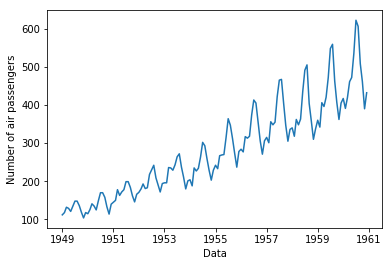

In [4]:
plt.xlabel("Data")
plt.ylabel("Number of air passengers")
plt.plot(indexedDataset)

Now we want to check stationarity. First, lets look at the rolling mean and std.

In [5]:
rolmean = indexedDataset.rolling(window=12).mean()

rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01          NaN
1949-07-01          NaN
1949-08-01          NaN
1949-09-01          NaN
1949-10-01          NaN
1949-11-01          NaN
1949-12-01   126.666667
1950-01-01   126.916667
1950-02-01   127.583333
1950-03-01   128.333333
1950-04-01   128.833333
1950-05-01   129.166667
1950-06-01   130.333333
1950-07-01   132.166667
1950-08-01   134.000000
1950-09-01   135.833333
1950-10-01   137.000000
1950-11-01   137.833333
1950-12-01   139.666667
1951-01-01   142.166667
1951-02-01   144.166667
1951-03-01   147.250000
1951-04-01   149.583333
1951-05-01   153.500000
1951-06-01   155.916667
...                 ...
1958-07-01   376.333333
1958-08-01   379.500000
1958-09-01   379.500000
1958-10-01   380.500000
1958-11-01   380.916667
1958-12-01   381.000000
1959-01-01   382.666667
1959-02-01   384.666667
1959-03-01   388

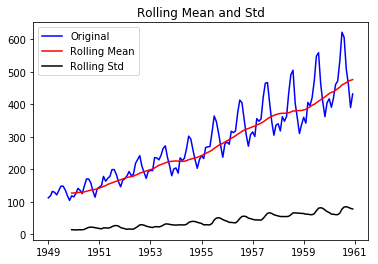

In [6]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean and Std')
plt.show(block=False)

It appears the data is not stationary. Note the trend in the rolling mean. But, let's run the Dickey-Fuller test to be certain.

In [7]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test: ')
dftest = adfuller(indexedDataset['#Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'nLags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical value(%s)' %key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 
Test Statistic                   0.815369
p-value                          0.991880
nLags Used                      13.000000
Number of Observations Used    130.000000
Critical value(5%)              -2.884042
Critical value(10%)             -2.578770
Critical value(1%)              -3.481682
dtype: float64


The null hypothesis states that the p-value should be small. Note that, because the p-value is high, and the 'Test Statistic' is not approximately equal to the 'Critical value(1%)', the data is not stationary. Let's estimate the trend. 

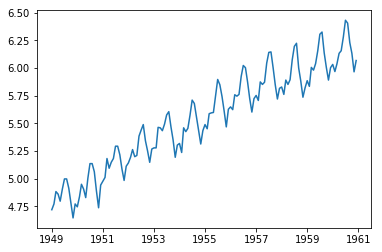

In [8]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

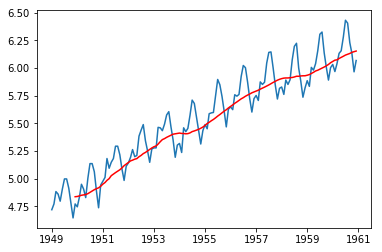

In [9]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingStd = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

The mean is not stationary, but it is getting closer. Now we'll subtract the moving average to try to make the data stationary.

In [10]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage

datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(12)

,#Passengers
Month,
1949-12-01,-0.065494
1950-01-01,-0.093449
1950-02-01,-0.007566
1950-03-01,0.099416
1950-04-01,0.052142
1950-05-01,-0.027529
1950-06-01,0.139881
1950-07-01,0.260184
1950-08-01,0.248635


The steps in the following function was already performed before. Now we are just making it into a neater function.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # find moving avg and std
    movingAverage = timeseries.rolling(window=12).mean()
    movingStd = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingStd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Std')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    # If the 'Test Statistic' and 'Critical Value(1%)' are approximately
    # equal, your data is stationary
    print('Results of Dickey-Fuller Test: ')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'nLags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)' %key] = value
    print(dfoutput)

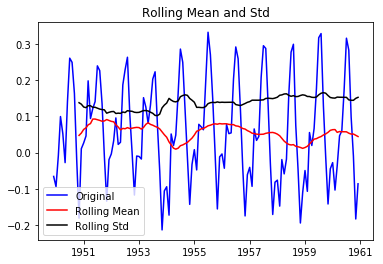

Results of Dickey-Fuller Test: 
Test Statistic                  -3.162908
p-value                          0.022235
nLags Used                      13.000000
Number of Observations Used    119.000000
Critical value(5%)              -2.886151
Critical value(10%)             -2.579896
Critical value(1%)              -3.486535
dtype: float64


In [12]:
test_stationarity(datasetLogScaleMinusMovingAverage)

Note, that there is relatively no trend now among the moving average and std. Also, the p-value is very low. Our data is much closer to being stationary. Let's perform a couple more steps.

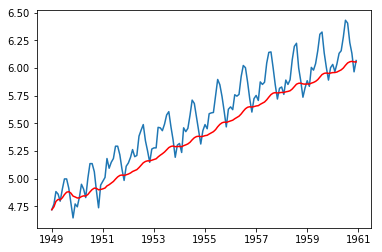

In [13]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

Note that, as the time series progresses, so does the exponential decay. Also, the rolling average is becoming more constant (linear).

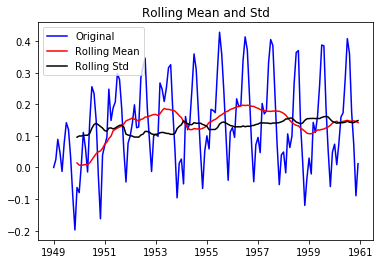

Results of Dickey-Fuller Test: 
Test Statistic                  -3.601262
p-value                          0.005737
nLags Used                      13.000000
Number of Observations Used    130.000000
Critical value(5%)              -2.884042
Critical value(10%)             -2.578770
Critical value(1%)              -3.481682
dtype: float64


In [14]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

Notice that the std is quite flat and has relatively no trend. Also, the p-value is very low, therefore, the dataset is stationary.

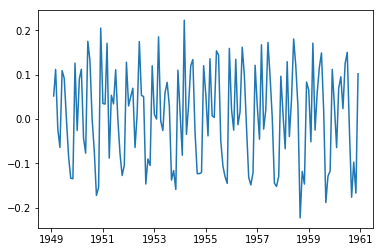

In [15]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

We've shifted the values, or differentiated, by one so we can use the data for time series forcasting. (see the ARIMA model for time series forecasting)

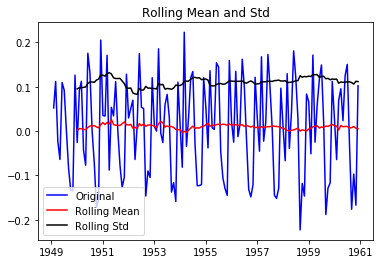

Results of Dickey-Fuller Test: 
Test Statistic                  -2.717131
p-value                          0.071121
nLags Used                      14.000000
Number of Observations Used    128.000000
Critical value(5%)              -2.884398
Critical value(10%)             -2.578960
Critical value(1%)              -3.482501
dtype: float64


In [16]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

Note the relative flatness of our rolling mean. Also, our 'Test Statistic' is more greater than the 'Critical value(1%)'. We can safely say that our dataset is now stationary. Now we will analyze the components of the time series.

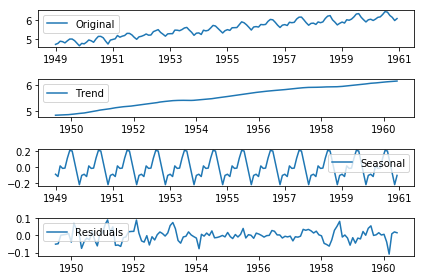

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Let's now check the noise (Residuals) to see if it is stationary

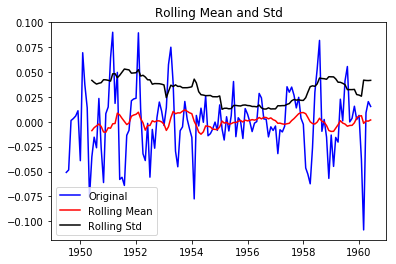

Results of Dickey-Fuller Test: 
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
nLags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical value(5%)            -2.885538e+00
Critical value(10%)           -2.579569e+00
Critical value(1%)            -3.485122e+00
dtype: float64


In [18]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

The noise residuals appear completely random, which is what we hope for. We don't want to remove anything that has an actual affect on the forecast.

Remember, we are using the ARIMA model, where AR(P), I(D), and MA(Q).

We were able to pull out the residuals by differentiating by 1, so now we know the value of D, but we still need the value of P and Q, i.e., the value of autoregressive lags and the value of the moving average. 

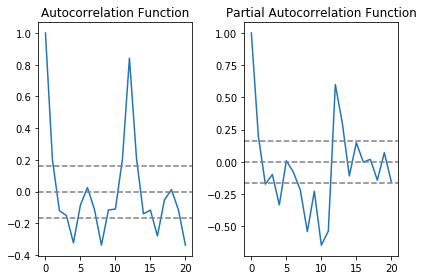

In [19]:
#ACF and PCF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In order to calculate the P and Q values, we find where the graphs drop to zero for the first time. Note, for the Autocorrelation function, the graph drops to zero for the first time at 2. For the Partial Autocorrelation Function, the graph drops to zero for the first time at 2. Now we substitute the values of P, D, and Q into the ARIMA model.

/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model


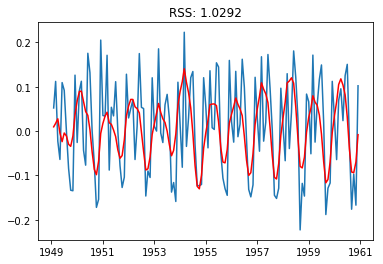

In [20]:
#AR Model
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

The RSS is quite good at 1.02. Note, the greater the RSS, the worse our model is.

Now we build our predictive model.

In [21]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


In [22]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64


In [23]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['#Passengers'].ix[0], index=indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Note, we take the exponential to bring the predictions to the original form

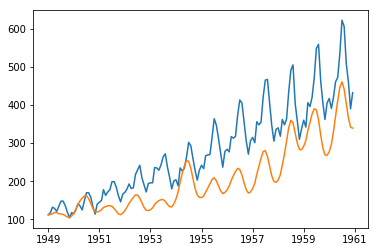

In [24]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

Note how, although the magnitude is off, however, the shape is properly captured by the ARIMA model. Now, let's make predictions! First, we need to find out how many rows are in the dataset.

In [25]:
indexedDataset_logScale

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
1949-06-01,4.905275
1949-07-01,4.997212
1949-08-01,4.997212
1949-09-01,4.912655


There are 144 rows. If we want to predict the number of airline passengers in 10 years, we add 120 to the total number of rows.

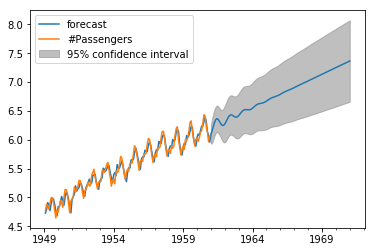

In [27]:
results_ARIMA.plot_predict(1, 264)
x = results_ARIMA.forecast(steps=120)